### 0. (Optional) Extract video file

In [ ]:
# import cv2
# import os

# capture = cv2.VideoCapture("./dataset/lane_with_object_2.mp4")
# assert capture.isOpened(), "Cannot open the video file."

# num_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
# print(num_frames)
# # Prepare folders
# img_filename_fmt = 'dataset/images/lane_with_object_2_frame_{:09d}.jpg'
# dirname = os.path.dirname(img_filename_fmt)
# os.makedirs(dirname, exist_ok=True)

# for ii in range(num_frames):
#     _, frame = capture.read()
#     cv2.imwrite(img_filename_fmt.format(ii), frame)

# capture.release()

1517


### 1. Label images

- Assume all images have same size

In [ ]:
# import cv2, os, re
# from collections import OrderedDict
# from ipywidgets import IntSlider, Label, Button, HBox
# from ipycanvas import MultiCanvas, hold_canvas

# # ── 경로 & 패턴 ───────────────────────────────────────────
# img_filename_fmt = 'dataset/images/lane_with_object_2_frame_{:09d}.jpg'
# img_dir = os.path.dirname(img_filename_fmt)
# ann_filename = 'dataset/annotation.txt'
# ann_dict = OrderedDict()

# # ① 실제 파일 번호만 추출
# pat = re.compile(r'^lane_with_object_2_frame_(\d+)\.jpg$')
# frame_ids = sorted(int(pat.match(f).group(1))
#                    for f in os.listdir(img_dir) if pat.match(f))
# if not frame_ids:
#     raise RuntimeError("폴더에 파일이 없습니다")

# idx_pos  = 0                        # frame_ids 안에서의 현재 위치
# cur_id   = frame_ids[idx_pos]       # 실제 프레임 번호

# # ② 첫 이미지 크기 얻기
# first_img = cv2.imread(img_filename_fmt.format(cur_id))
# h, w = first_img.shape[:2]
# thickness, y_ratio = 3, 0.8
# y_value = int(h * y_ratio)

# # ── 캔버스 초기화 ─────────────────────────────────────────
# canvas = MultiCanvas(3, width=w, height=h)
# cur_fname = Label(); cur_pos = Label()
# yslider = IntSlider(description='Y-bar: ',
#                     style={'description_width':'initial'},
#                     value=y_value, min=1, max=h-2, step=1)

# # ── 함수들 ────────────────────────────────────────────────
# def set_image():
#     global cur_id
#     path = img_filename_fmt.format(cur_id)
#     img  = cv2.imread(path)
#     if img is None:                 # 혹시 삭제됐을 때 대비
#         print(f'⚠️ {path} 로드 실패, 다음으로 건너뜀')
#         handle_next(None); return
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img[y_value-thickness//2 : y_value+thickness//2] = (255,0,0)
#     canvas[0].clear(); canvas[0].put_image_data(img,0,0); canvas[0].flush()
#     if path in ann_dict: handle_mouse_down(*ann_dict[path])
#     cur_fname.value = f'Current image: {path} | '

# def handle_prev(_):
#     global idx_pos, cur_id
#     idx_pos = max(0, idx_pos-1); cur_id = frame_ids[idx_pos]
#     canvas.clear(); set_image()

# def handle_next(_):
#     global idx_pos, cur_id
#     idx_pos = min(len(frame_ids)-1, idx_pos+1); cur_id = frame_ids[idx_pos]
#     canvas.clear(); set_image()

# def handle_key(k, *a):
#     if k=='d': handle_next(None)
#     elif k=='a': handle_prev(None)

# def handle_mouse_move(x, _):
#     with hold_canvas():
#         canvas[1].clear()
#         canvas[1].fill_style='yellow'; canvas[1].fill_circle(x, y_value, 5)

# def handle_mouse_down(x, _):
#     with hold_canvas():
#         canvas[2].clear()
#         canvas[2].fill_style='green'; canvas[2].fill_circle(x, y_value, 5)
#     cur_pos.value = f'({int(x)}, {y_value})'
#     ann_dict[img_filename_fmt.format(cur_id)] = (x, y_value)

# def save(_):
#     with open(ann_filename,'w') as f:
#         for k,(x,y) in ann_dict.items():
#             f.write(f'{k}\t{int(x)}\t{int(y)}\n')

# # ── 위젯 배선 & 첫 이미지 ─────────────────────────────────
# prev_btn = Button(description='Prev', icon='arrow-left')
# next_btn = Button(description='Next', icon='arrow-right')
# save_btn = Button(description='Save', icon='check')

# canvas.on_mouse_move(handle_mouse_move)
# canvas.on_mouse_down(handle_mouse_down)
# canvas.on_key_down(handle_key)
# yslider.observe(lambda ch: (globals().__setitem__('y_value', ch.new), set_image()), names='value')

# prev_btn.on_click(handle_prev); next_btn.on_click(handle_next); save_btn.on_click(save)
# set_image()

# display(canvas, HBox([cur_fname, cur_pos, yslider]), HBox([prev_btn, next_btn, save_btn]))


MultiCanvas(height=540, width=960)

### 2. Train a model

In [ ]:
import torch
import torchvision

def get_model():
    model = torchvision.models.alexnet(num_classes=2, dropout=0.0)
    return model

device = torch.device('cuda')
model = get_model()
model = model.to(device)

In [ ]:
import torch
from cnn.center_dataset import CenterDataset

batch_size = 16

dataset = CenterDataset('dataset', random_hflip=False)
train_loader = torch.utils.data.DataLoader(
    dataset,
    num_workers=0,
    batch_size=batch_size,
    shuffle=True,
)

In [ ]:
import ipywidgets
import torch.nn.functional as f

epoch = 200
learning_rate = 2e-3
# learning_rate = 2e-4

epoch_slider = ipywidgets.IntSlider(description='Epochs', value=epoch, min=1, max=200, step=1)
lr_slider = ipywidgets.FloatSlider(description='lr', value=learning_rate, min=1e-4, max=1e-2, step=1e-4, readout_format='.4f')
train_button = ipywidgets.Button(description='Train', icon='tasks')
loss_text = ipywidgets.Textarea(description='Progress', value='', rows=15, layout=ipywidgets.Layout(width="50%", height="auto"))
layout = ipywidgets.VBox([ipywidgets.HBox([epoch_slider, lr_slider, train_button]), loss_text])


def train_model(b):
    global epoch_slider
    for epoch in range(epoch_slider.value):
        loss_text.value += "<<<<< Epoch {:d} >>>>>\n".format(epoch)
        train_step()


def train_step():
    global model, lr_slider, loss_text, train_laoder, device

    try:
        # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr_slider.value, momentum=0.9)

        train_button.disabled = True
        model = model.train()

        num_iters = len(train_loader)
        for ii, (images, labels) in enumerate(train_loader):
            # send data to device
            images = images.to(device)
            labels = labels.to(device)

            # zero gradients of parameters
            optimizer.zero_grad()

            # execute model to get outputs
            outputs = model(images)

            # compute MSE loss over x coordinates
            loss = f.mse_loss(outputs, labels, reduction='sum')

            # run backpropogation to accumulate gradients
            loss.backward()

            # step optimizer to adjust parameters
            optimizer.step()

            if ii % 10 == 0:
                xlbl, ylbl = labels[0].cpu()
                xlbl = ( xlbl.item() / 2 + 0.5 ) * 800
                ylbl = ( ylbl.item() / 2 + 0.5 ) * 450

                xpre, ypre = outputs[0].cpu()
                xpre = ( xpre.item() / 2 + 0.5 ) * 800
                ypre = ( ypre.item() / 2 + 0.5 ) * 450

                msg = "[{:04d} / {:04d}] loss: {:.4f} | labels: ({:.2f}, {:.2f}), outpus: ({:.2f}, {:.2f})\n".format(ii, num_iters, loss.item(), xlbl, ylbl, xpre, ypre)
                loss_text.value += msg

    except Exception as e:
        print(e)
        pass

    model = model.eval()
    torch.save(model.state_dict(), 'road_following_model.pth')

    train_button.disabled = False

train_button.on_click(train_model)

display(layout)

# Inference Code

In [2]:
import PIL.Image
from cnn.center_dataset import TEST_TRANSFORMS
import torch
import torchvision


image_ori = # 실시간 이미지 받기
width = image_ori.shape[0]
height = image_ori.shape[1]

def preprocess(image: PIL.Image):
    device = torch.device('cuda')
    image = TEST_TRANSFORMS(image).to(device)
    return image[None, ...]


def get_model():
    model = torchvision.models.alexnet(num_classes=2, dropout=0.0)
    return model

model = get_model()
model.load_state_dict(torch.load('last_lane.pt',weights_only=True))
model = model.to('cuda')

with torch.no_grad():
    # 여기서 이미지 넣어서
    image = preprocess(image_ori)
    output = model(image).detach().cpu().numpy()

x, y = output[0]

# 이미지 width,height
x = (x / 2 + 0.5) * width
y = (y / 2 + 0.5) * height
print(x, y)




SyntaxError: invalid syntax (2406706943.py, line 7)

In [3]:
import PIL.Image
from cnn.center_dataset import TEST_TRANSFORMS
import torch
import torchvision

def preprocess(image: PIL.Image):
    device = torch.device('cuda')
    image = TEST_TRANSFORMS(image).to(device)
    return image[None, ...]


def get_model():
    model = torchvision.models.alexnet(num_classes=2, dropout=0.0)
    return model

In [4]:
model = get_model()
model.load_state_dict(torch.load('last_lane.pt',weights_only=True))
model = model.to('cuda')

# from torch2trt import TRTModule
# model = TRTModule()
# model.load_state_dict(torch.load('road_following_model.pth'))

568.092770576477 399.96004343032837


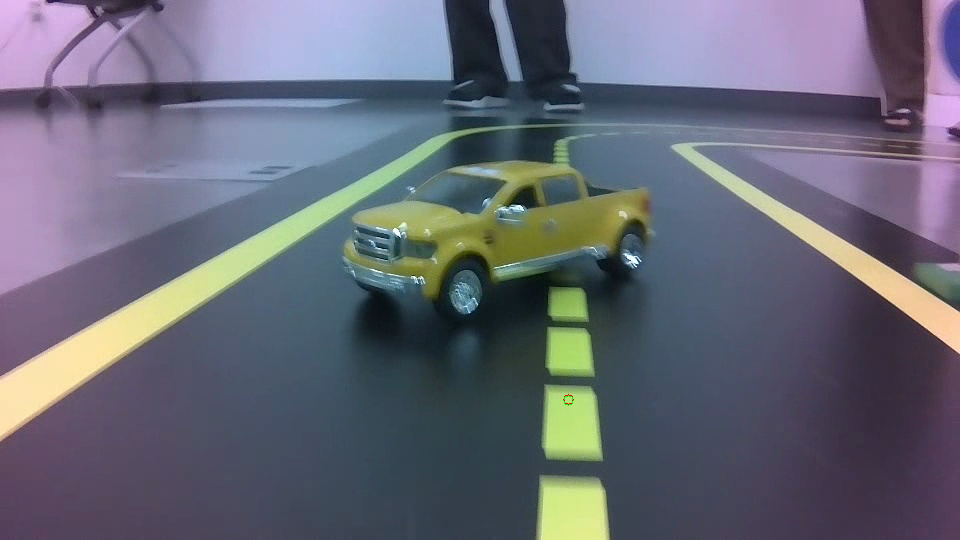

In [5]:
import cv2
import copy
import numpy as np
import PIL.Image

img_filename_fmt = 'dataset/images/frame_{:09d}.jpg'
ann_filename = 'dataset/annotation_1.txt'
with open(ann_filename, 'r') as f:
    data = [line.split() for line in f.readlines()]

filename, xpos, ypos = data[825]

xpos = int(xpos)
ypos = int(ypos)

image_ori = PIL.Image.open(filename)
width = image_ori.width
height = image_ori.height

with torch.no_grad():
    image = preprocess(image_ori)
    output = model(image).detach().cpu().numpy()
x, y = output[0]

x = (x / 2 + 0.5) * width
y = (y / 2 + 0.5) * height
print(x, y)

# 디버깅용
image_np = copy.deepcopy(np.asarray(image_ori))
cv2.circle(image_np, (int(x), int(y)), radius=5, color=(255, 0, 0))  # Pred
cv2.circle(image_np, (xpos, ypos), radius=5, color=(0, 255, 0))     # GT

PIL.Image.fromarray(image_np)

